# PatchMatch

**Imports**

In [78]:
# Navigate to appropriate directory
import os
while os.path.split(os.getcwd())[1] != "patchmatch":
    os.chdir("..")
    if os.getcwd() == "/":
        raise ValueError()

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from time import time
from tqdm import tqdm
import cv2 as cv

import patchmatch as pm
import detection as dt

**Matplotlib display mode**

In [2]:
# Run this cell to display matplotlib plots in a separate window
%matplotlib qt

In [3]:
# Run this cell to display matplotlib plots inside the jupyter notebook
%matplotlib inline

In the following sections, we test the PatchMatch algorithm on 2 different images with copy-move forgery: one with a simple translation and one with a translation and a rotation.

## Image 1: Antibes

### Load image 

In [79]:
im = Image.open("data/TP_C02_007_copy.png")
im = np.array(im).astype("double")
gt = Image.open("data/TP_C02_007_gt.png")
gt = np.array(gt) > 0

### Initialize Patchmatch

Expected runtime with init_method=1 and zernike=True (p=10, max_zrd=6): 54s   
Expected runtime with init_method=2 and zernike=True (p=10, max_zrd=6): 55s   
Expected runtime with init_method=1 and zernike=False (p=10, max_zrd=6): 5s   
Expected runtime with init_method=2 and zernike=False (p=10, max_zrd=6): 5s   

In [80]:
t0 = time()
a = pm.PatchMatch(
    im,  # image
    p=10,  # patch half-size
    max_zrd=6,  # maximum Zernike degree
    min_dn=64,   # minimum displacement norm (previously T)
    n_rs_candidates=5,   # number of candidates in the random search phase (previously L)
    init_method=2,  # whether to use create_vect_field1 or create_vect_field2
    zernike=True  # whether to use Zernike moments
)
t1 = time()
print(t1 - t0)

99.65579533576965


### Run PatchMatch

Expected running time with zernike=True (max_zrd=6): <10s for each iteration (1 iteration = 2 scans)

In [81]:
t0 = time()
a.run(5)
t1 = time()
print(t1 - t0)

59.500828981399536


In [82]:
a.get_min_displacement_norm()

64

### Plot results

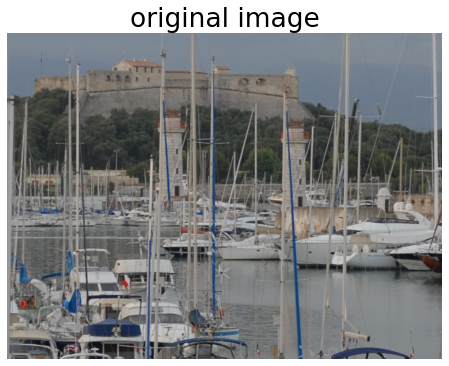

In [83]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(16,6))
plt.title('original image')
plt.imshow(im.astype("uint8"))
plt.axis("off")
plt.show()

In [84]:
def plot_vect_field(pm_, mask, step=100, **kwargs):
    """
    Plot vect_field as arrows above the image
    
    Parameters
    ----------
    pm_ : instance of PatchMatch
    mask : array-like, shape (m, n)
        only vectors whose "roots" are on pixels for wich mask is non-zero will be plotted
    step : int
        step between two plotted vectors
    **kwargs : keyword arguments
        keyword arguments to be passed to plt.arrow (e.g. head_width, head_length, ...)
    """
    default_kwargs = {"width": 1e-3, "head_width": 1, "head_length": 1.5, "length_includes_head": True}
    default_kwargs.update(kwargs)
    default_kwargs["head_length"] = 1.5 * default_kwargs["head_width"]
    plt.imshow(pm_.im.astype("uint8"))
    for i in range(0, pm_.m, step):  # for each pixel in the mask
        for j in range(0, pm_.n, step):
            if mask[i, j] > 0:
                plt.arrow(j, i, *pm_.vect_field[i, j, ::-1], **default_kwargs)
    plt.axis("off")

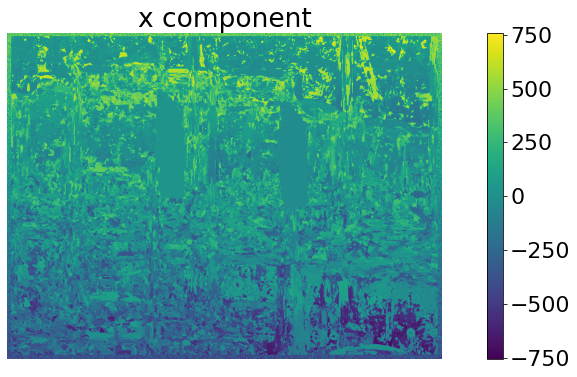

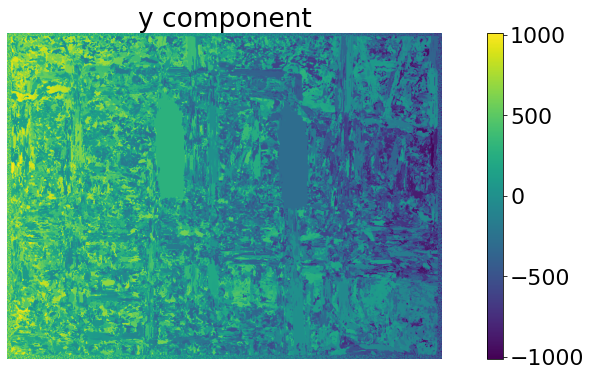

In [85]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(16,6))
plt.title('x component')
plt.imshow(a.vect_field[..., 0]) #, vmin=0, vmax=60)
plt.colorbar()
plt.axis("off")
plt.show()
plt.figure(figsize=(16,6))
plt.title('y component')
plt.imshow(a.vect_field[..., 1]) #, vmin=0, vmax=60)
plt.colorbar()
plt.axis("off")
plt.show()
# plt.figure(figsize=(16,6))
# plt.title('Norm of displacement vectors')
# plt.imshow(np.sqrt(a.vect_field[..., 0]**2 + a.vect_field[..., 1]**2)) #, vmin=0, vmax=60)
# plt.colorbar()
# plt.show()

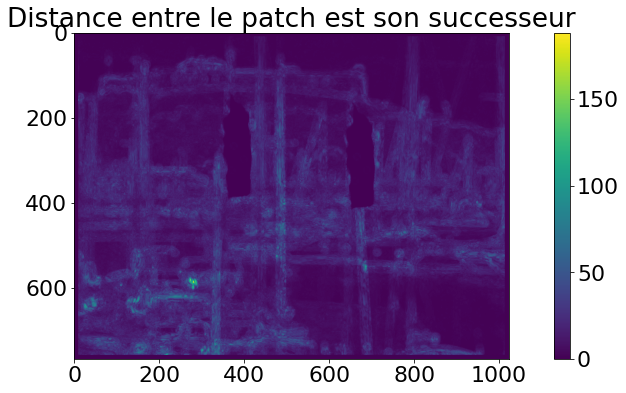

In [86]:
plt.figure(figsize=(16,6))
plt.title('Distance entre le patch est son successeur')
plt.imshow(a.dist_field)
plt.colorbar()
plt.show()

In [87]:
mask, number_detection = dt.compute_mask(a.vect_field, a.n, a.m, a.p)
print('We detection {} detection'.format(number_detection))

We detection 1 detection


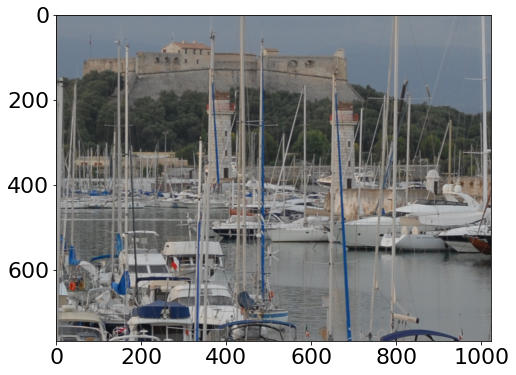

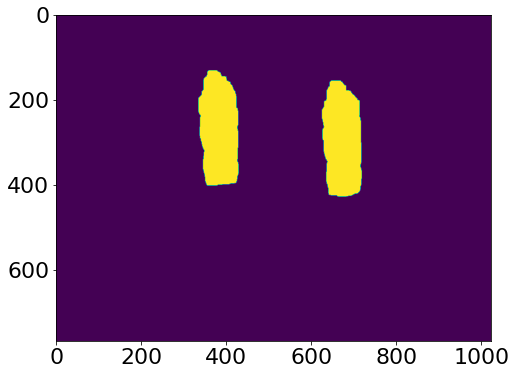

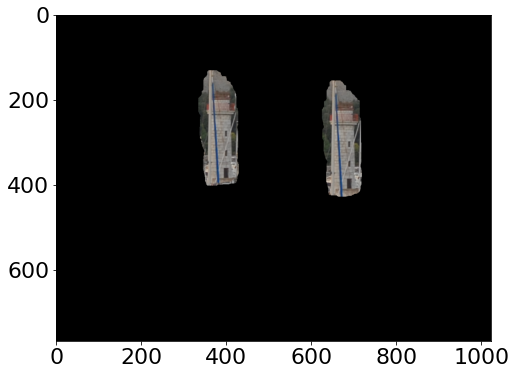

In [88]:
plt.figure(figsize=(16,6))
plt.imshow(im.astype("uint8"))
plt.show()

plt.figure(figsize=(16,6))
plt.imshow(mask)
plt.show()

plt.figure(figsize=(16,6))
plt.imshow((mask[:,:,None]*im).astype("uint8"))
plt.show()

In [ ]:
r = p
th = 0.5
th_comp = 0.05
s = 2*p
#Compute the gradn of x and y displacement map
vx = gradn(vect_field[..., 0])
vy = gradn(vect_field[..., 1])

#Compute a first mask
mask_0 = np.zeros((m,n))
u = (np.mean(vx)+np.mean(vy))/100
mask_0[:-1,:-1] = 1*(vy<u)*(vx<u)

#Filter a big part of the noise
kernel = np.ones((r,r))
kernel = kernel /np.sum(kernel)
mask_1 = cv.filter2D(mask_0, -1, kernel) 
mask_2 = 1*(mask_1>th)

#look at connexe component to keep just biggest ones
mask_3 = np.uint8((mask_2))
N, component = cv.connectedComponents(mask_3)
white_pixel = np.sum(mask_2)

Liste_component = []
for i in range(1,N):
    #we keep just component which as more than 5% of white pixels
    if np.sum(1*(component==i))/white_pixel > th_comp:
        Liste_component.append(i)
mask_4 = np.zeros((m,n))
number_detection = len(Liste_component)//2
for i in Liste_component:
    mask_4 += 1*(component==i)

#dilatate the result to compensate the patch effect
kernel = np.ones((s,s))
mask = cv.dilate(mask_4, kernel)

# Image 2 : Leaf

In [12]:
im = Image.open("data/feuille_copy_move.png")
im = np.array(im).astype("double")

In [13]:
t0 = time()
a = pm.PatchMatch(
    im,  # image
    p=10,  # patch half-size
    max_zrd=6,  # maximum Zernike degree
    min_dn=64,   # minimum displacement norm (previously T)
    n_rs_candidates=5,   # number of candidates in the random search phase (previously L)
    init_method=2,  # whether to use create_vect_field1 or create_vect_field2
    zernike=True  # whether to use Zernike moments
)
t1 = time()
print(t1 - t0)

4.283277988433838


In [14]:
t0 = time()
a.run(5)
t1 = time()
print(t1 - t0)

2.7716269493103027


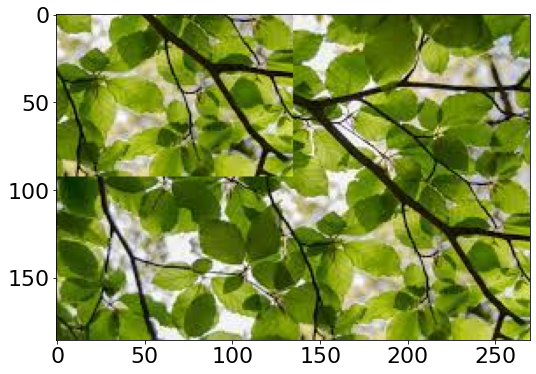

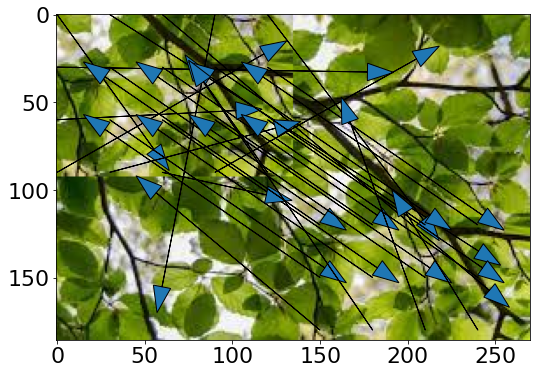

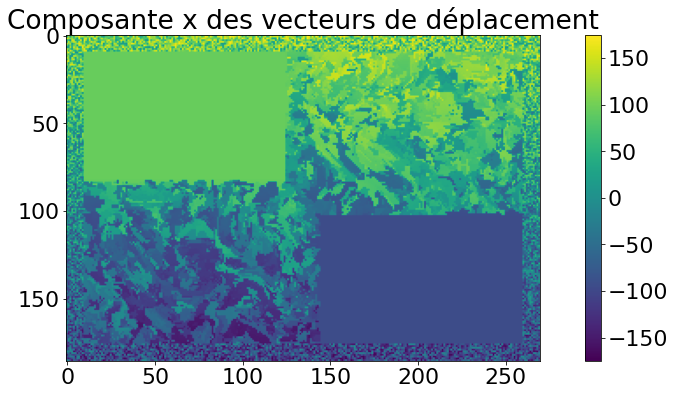

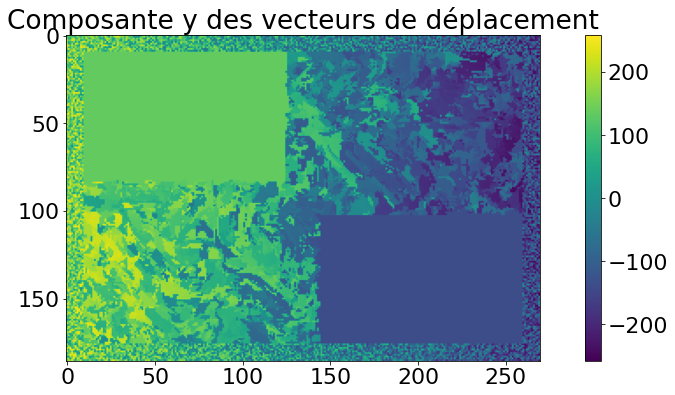

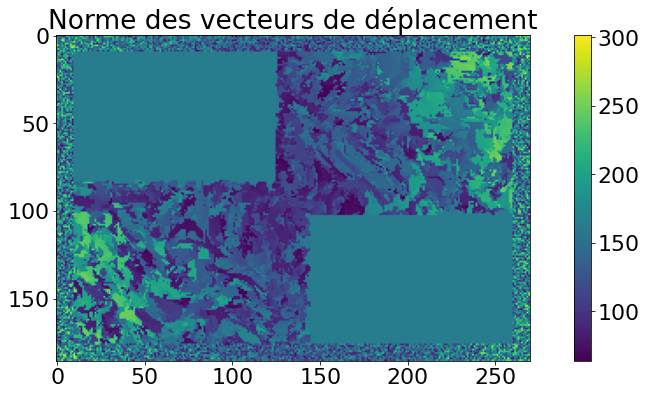

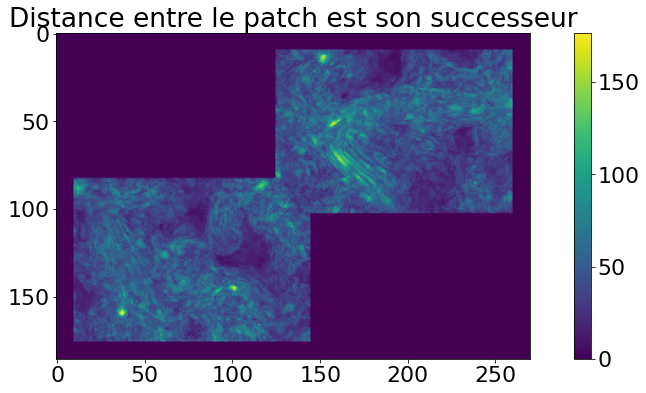

In [15]:
plt.figure(figsize=(16,6))
plt.imshow(im.astype("uint8"))
plt.show()

gt = np.zeros((a.m,a.n))
gt[:a.m//2,:a.n//2] = np.ones((a.m//2,a.n//2))
gt[a.m//2:,a.n//2:] = np.ones((a.m//2,a.n//2))
plt.figure(figsize=(16,6))
pm.plot_vect_field(a, gt, step=30, head_width=10)
plt.show()

plt.figure(figsize=(16,6))
plt.title('Composante x des vecteurs de déplacement')
plt.imshow(a.vect_field[..., 0]) #, vmin=0, vmax=60)
plt.colorbar()
plt.show()
plt.figure(figsize=(16,6))
plt.title('Composante y des vecteurs de déplacement')
plt.imshow(a.vect_field[..., 1]) #, vmin=0, vmax=60)
plt.colorbar()
plt.show()
plt.figure(figsize=(16,6))
plt.title('Norme des vecteurs de déplacement')
plt.imshow(np.sqrt(a.vect_field[..., 0]**2 + a.vect_field[..., 1]**2)) #, vmin=0, vmax=60)
plt.colorbar()
plt.show()

plt.figure(figsize=(16,6))
plt.title('Distance entre le patch est son successeur')
plt.imshow(a.dist_field)
plt.colorbar()
plt.show()

In [16]:
mask, number_detection = dt.compute_mask(a.vect_field, a.n, a.m, a.p)
print('We detection {} detection'.format(number_detection))

We detection 1 detection


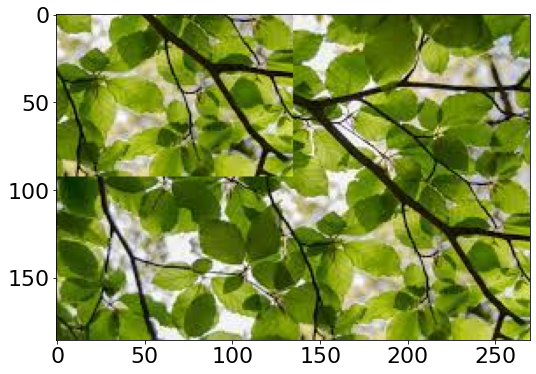

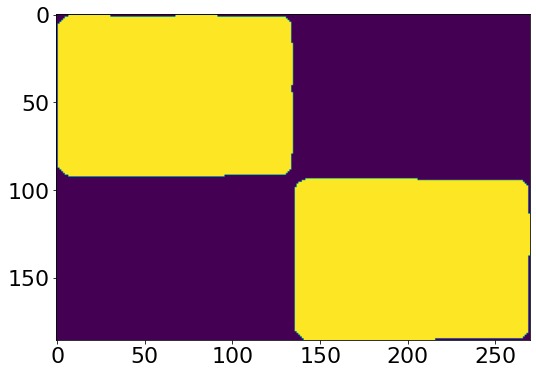

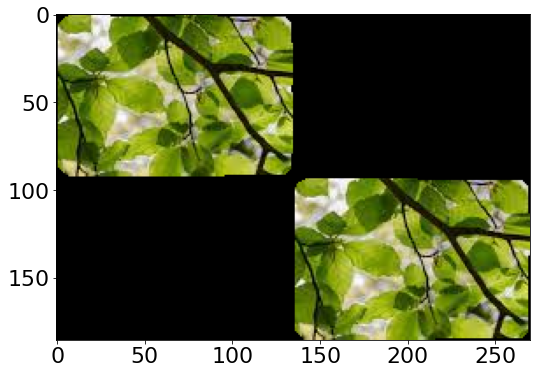

In [17]:
plt.figure(figsize=(16,6))
plt.imshow(im.astype("uint8"))
plt.show()

plt.figure(figsize=(16,6))
plt.imshow(mask)
plt.show()

plt.figure(figsize=(16,6))
plt.imshow((mask[:,:,None]*im).astype("uint8"))
plt.show()

## Image 2: Flowers

### Load image 

In [18]:
im2 = Image.open("data/TP_C01_039_copy_r45.png")
im2 = np.array(im2).astype("double")
gt2 = Image.open("data/TP_C01_039_gt_r45.png")
gt2 = np.array(gt2) > 0

### Initialize Patchmatch

In [19]:
t0 = time()
a2 = pm.PatchMatch(
    im2,  # image
    p=10,  # patch half-size
    max_zrd=6,  # maximum Zernike degree
    min_dn=64,   # minimum displacement norm (previously T)
    n_rs_candidates=5,   # number of candidates in the random search phase (previously L)
    init_method=2,  # whether to use create_vect_field1 or create_vect_field2
    zernike=True  # whether to use Zernike moments
)
t1 = time()
print(t1 - t0)

72.20421719551086


### Analyze Zernike moments

Plot Zernike filters

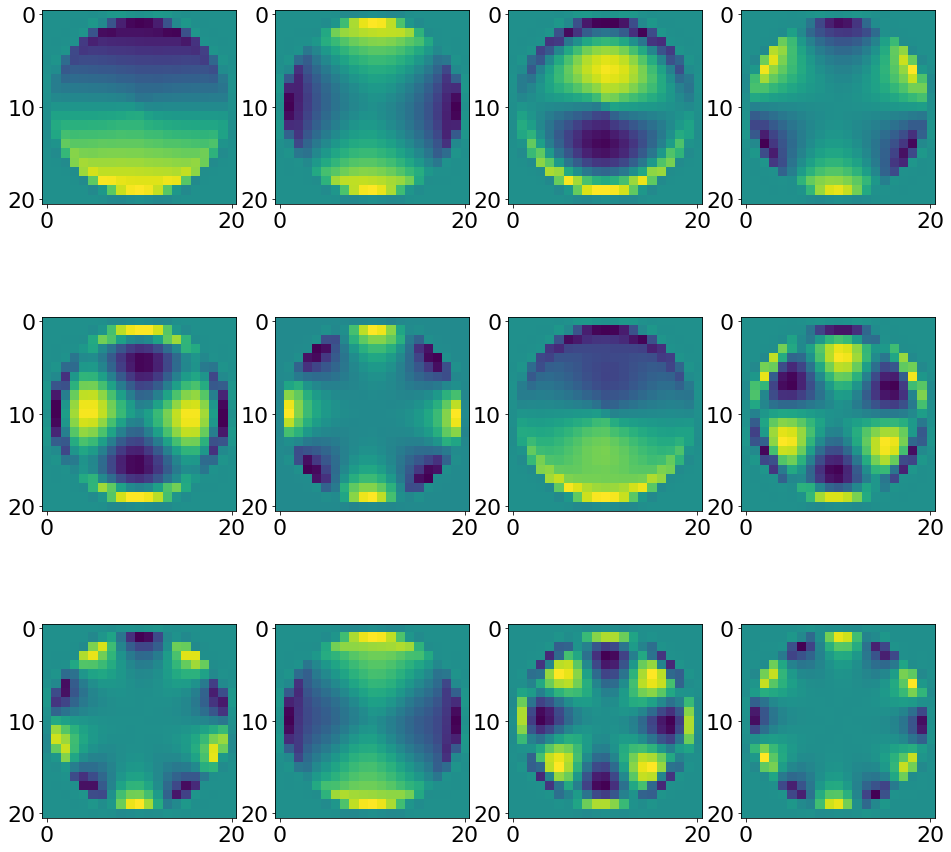

In [20]:
plt.figure(figsize=(16,16))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.imshow(a2.zernike_filters[..., i].real)
plt.show()

Get Zernike moments of 3 different patches: 1 et 2 should have the same Zernike moments (rotation invariance), whereas the "control" patch should be quite different.

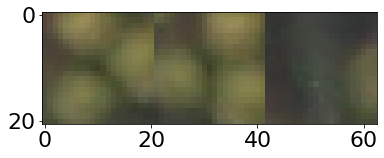

In [21]:
# Show patches 1, 2 and control
plt.imshow(np.concatenate((a2.patch(577, 768), a2.patch(379, 832), a2.patch(128, 988)), axis=1).astype("uint8"))
plt.show()

In [22]:
# Get their Zernike moments
zm1 = a2.zernike_moments[577, 768]
zm2 = a2.zernike_moments[379, 832]
zm_control = a2.zernike_moments[128, 988]

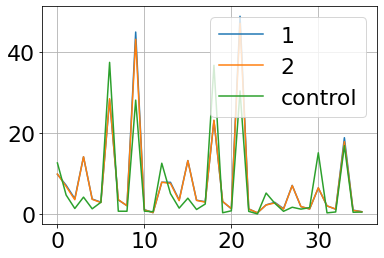

In [23]:
# Plot the Zernike moments
plt.plot(zm1, label="1")
plt.plot(zm2, label="2")
plt.plot(zm_control, label="control")
plt.legend()
plt.grid()
plt.show()

### Run PatchMatch

In [24]:
t0 = time()
a2.run(5)
t1 = time()
print(t1 - t0)

46.50756216049194


### Plot results

In [25]:
%matplotlib qt

In [26]:
%matplotlib inline

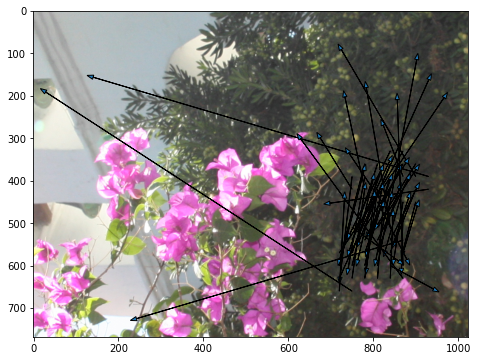

In [27]:
plt.figure(figsize=(16,6))
pm.plot_vect_field(a2, gt2, step=30, head_width=10)

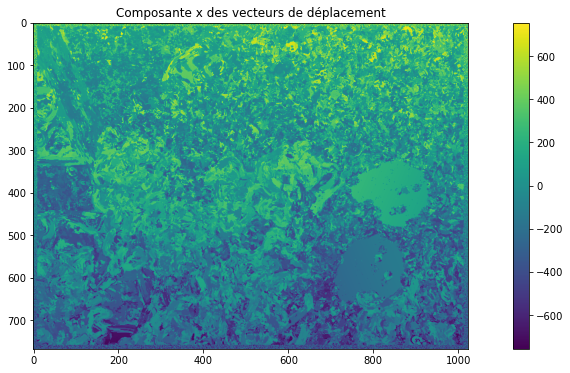

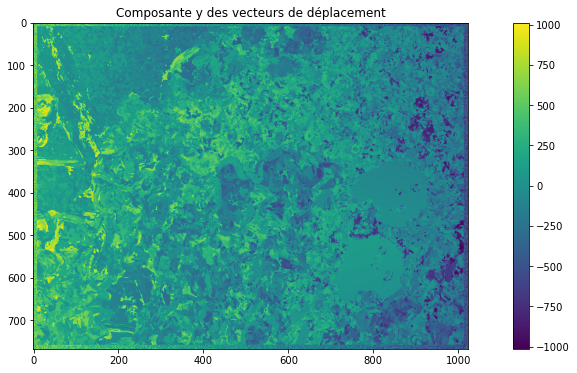

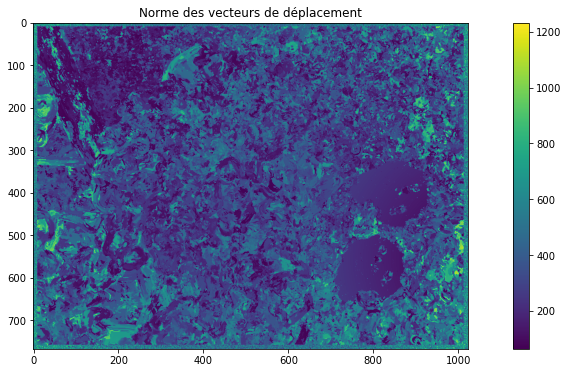

In [28]:
plt.figure(figsize=(16,6))
plt.title('Composante x des vecteurs de déplacement')
plt.imshow(a2.vect_field[..., 0]) #, vmin=0, vmax=60)
plt.colorbar()
plt.show()
plt.figure(figsize=(16,6))
plt.title('Composante y des vecteurs de déplacement')
plt.imshow(a2.vect_field[..., 1]) #, vmin=0, vmax=60)
plt.colorbar()
plt.show()
plt.figure(figsize=(16,6))
plt.title('Norme des vecteurs de déplacement')
plt.imshow(np.sqrt(a2.vect_field[..., 0]**2 + a2.vect_field[..., 1]**2)) #, vmin=0, vmax=60)
plt.colorbar()
plt.show()

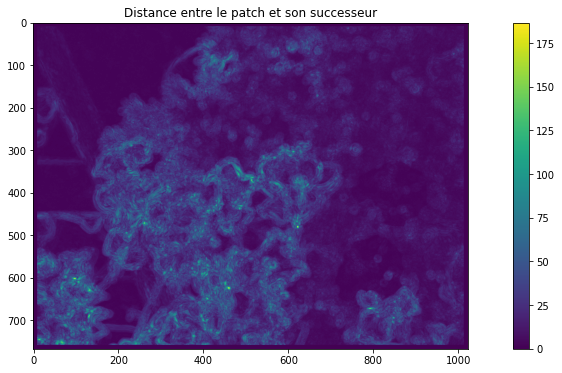

In [29]:
plt.figure(figsize=(16,6))
plt.title('Distance entre le patch et son successeur')
plt.imshow(a2.dist_field)
plt.colorbar()
plt.show()

In [30]:
mask, number_detection = dt.compute_mask(a2.vect_field, a2.n, a2.m, a2.p)
print('We detection {} detection'.format(number_detection))

We detection 1 detection


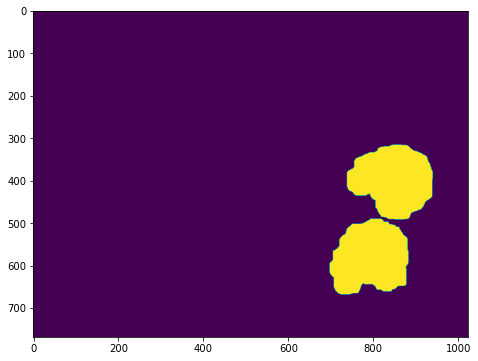

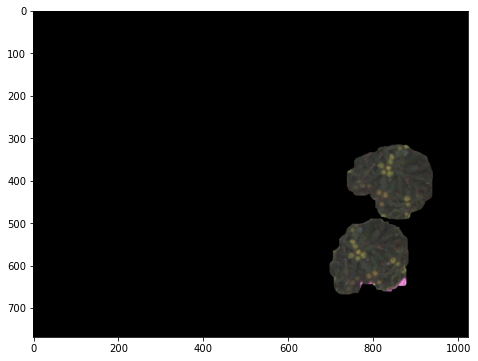

In [31]:
plt.figure(figsize=(16,6))
plt.imshow(mask)
plt.show()

plt.figure(figsize=(16,6))
plt.imshow((mask[:,:,None]*im2).astype("uint8"))
plt.show()

# Copy Move detection
We apply the copy move detection to the entire database

In [33]:
a = 'TP_C01_'
F = []
Names = []
for filename in tqdm(os.listdir("notebooks/results")):
    if filename[:7] == a:
        Names.append(filename)
        A = np.load('notebooks/results/'+filename)
        mask, _ = dt.compute_mask(A['vect_field'],A['n'], A['m'], A['p'])
        title = filename[:10]
        im = Image.open('data/'+title+'_gt.png')
        im = np.array(im).astype("double")

        TP = mask*im
        FP = 1*(mask>0)*(im<1)
        FN = (np.ones((A['m'], A['n']))-mask)*im
        F.append( 2 * np.sum(TP) /(2*np.sum(TP) + np.sum(FN) + np.sum(FP)))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:02<00:00,  1.61it/s]


In [34]:
F = np.array(F)
print('mean accuracy = ',np.mean(F))
print('std accuracy = ',np.std(F))

mean accuracy =  0.980546057221987
std accuracy =  0.0453050255980242


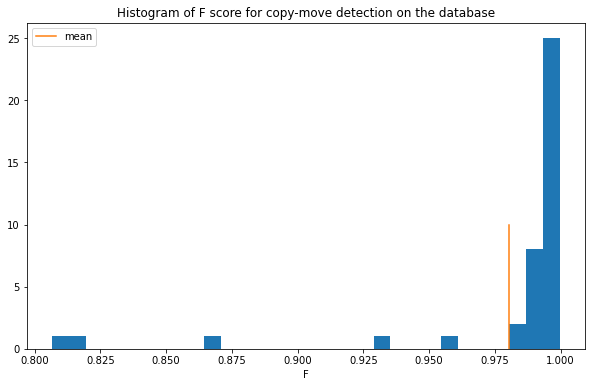

In [36]:
plt.figure(figsize=(10,6))
plt.title('Histogram of F score for copy-move detection on the database')
plt.xlabel('F')
plt.hist(F, 30)
plt.plot([np.mean(F),np.mean(F)],[0,10], label = 'mean')
plt.legend()
plt.show()

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 821.10it/s]


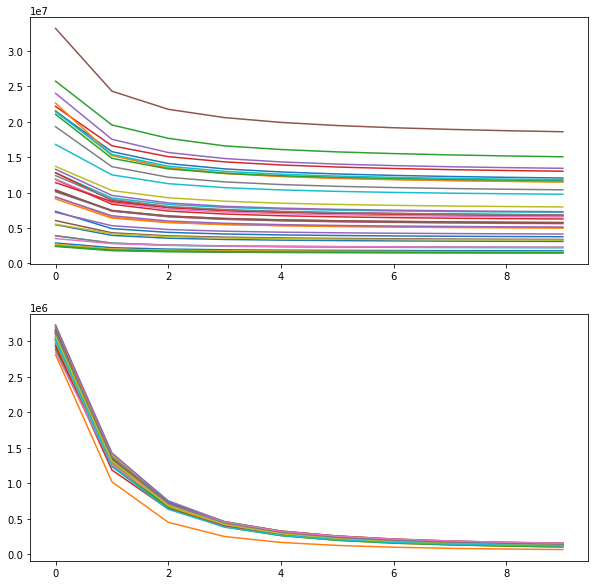

In [73]:
a = 'TP_C01_'
F = []
Names = []
plt.figure(figsize=(10,10))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212, sharex=ax1)
for filename in tqdm(os.listdir("notebooks/results2")):
    if filename[:7] == a:
        Names.append(filename)
        A = np.load('notebooks/results2/'+filename)
        ax1.plot(A['sum_of_distances'][:10])
        A = np.load('notebooks/results/'+filename)
        ax2.plot(A['n_propagations'][:10])

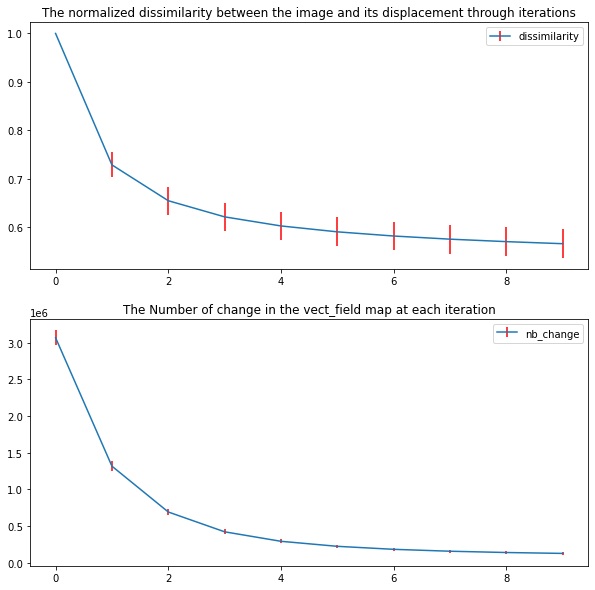

In [77]:
a = 'TP_C01_'
Sum = []
N_prop = []
Names = []

for filename in os.listdir("notebooks/results2"):
    if filename[:7] == a:
        Names.append(filename)
        A = np.load('notebooks/results2/'+filename)
        Sum.append(A['sum_of_distances'][:10]/A['sum_of_distances'][0])
        B = np.load('notebooks/results/'+filename)
        N_prop.append(B['n_propagations'][:10])

plt.figure(figsize=(10,10))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212, sharex=ax1)
X = np.arange(10)
        
Sum = np.array(Sum)
Sum_mean = np.mean(Sum,axis=0)
Sum_std = np.std(Sum,axis=0)
ax1.set_title('The normalized dissimilarity between the image and its displacement through iterations')
ax1.errorbar(X,Sum_mean,Sum_std, ecolor = 'r', label='dissimilarity')
ax1.legend()

N_prop = np.array(N_prop)
N_prop_mean = np.mean(N_prop,axis=0)
N_prop_std = np.std(N_prop,axis=0)
ax2.set_title('The Number of change in the vect_field map at each iteration')
ax2.errorbar(X,N_prop_mean,N_prop_std, ecolor = 'r', label='nb_change')
ax2.legend()

In [ ]:
#Test for similarity between the same detected object
indice = np.where(mask>=0)
I = indice[0]
J = indice[1]
m = A['m']
n = A['n']
indice_arrive = (np.array(indice) + vect_field[indice].T)
mask_arrive = mask[(indice_arrive[0],indice_arrive[1])]
plt.imshow(mask)
plt.show()
plt.imshow(mask_arrive.reshape((m,n)))
plt.show()



indice = np.where(mask==1)
I = indice[0]
J = indice[1]
vect_field = A['vect_field']
print('n = ',A['n'])
print('m = ',A['m'])

indice_arrive = (np.array(indice) + vect_field[indice].T)

dist = np.sum((im2[indice]-im2[(indice_arrive[0],indice_arrive[1])])**2)
plt.imshow((im2*mask[:,:,None]).astype("uint8"))
plt.show()
print(dist)